In [308]:
import pm4py as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [276]:
event_log : pd.DataFrame = pm.read_xes('hiring_log_high.xes')

parsing log, completed traces :: 100%|██████████| 10000/10000 [00:03<00:00, 2961.48it/s]
/home/chirag/anaconda3/envs/process-mining/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/chirag/anaconda3/envs/process-mining/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/chirag/anaconda3/envs/process-mining/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back

In [277]:
event_log.head()

,activity,resource,time,concept:name,time:timestamp,@@index,case:concept:name,case:german speaking,case:yearsOfEducation,case:age,case:gender,case:citizen,case:protected,case:@@case_index,case:case,case:religious
0,Hand In Job Application,Front Desk,2015-01-05 00:00:08+00:00,Hand In Job Application,2015-01-05 00:00:08+00:00,0,1,False,6,30,True,True,False,0,1,True
1,Telephonic Screening,HR-dummy,2015-01-05 22:12:58+00:00,Telephonic Screening,2015-01-05 22:12:58+00:00,1,1,False,6,30,True,True,False,0,1,True
2,Screening Interview,HR-dummy,2015-01-06 20:26:13+00:00,Screening Interview,2015-01-06 20:26:13+00:00,2,1,False,6,30,True,True,False,0,1,True
3,Background Check,HR-dummy,2015-01-06 20:26:13+00:00,Background Check,2015-01-06 20:26:13+00:00,3,1,False,6,30,True,True,False,0,1,True
4,Extensive Background Check,deepResearch Inc.,2015-01-07 18:41:19+00:00,Extensive Background Check,2015-01-07 18:41:19+00:00,4,1,False,6,30,True,True,False,0,1,True


In [278]:
# all activities
event_log['concept:name'].unique()

array(['Hand In Job Application', 'Telephonic Screening',
       'Screening Interview', 'Background Check',
       'Extensive Background Check', 'Coding Interview', 'ML Interview',
       'Frontend Interview', 'Behavioral Interview', 'Make Job Offer',
       'Application Rejected', 'Backend Interview'], dtype=object)

In [279]:
# case:concept:name is same as case:case
(event_log['case:concept:name'].astype('int64') == event_log['case:case']).sum() == event_log.shape[0]

True

In [280]:
# critical attributes = 'german speaking', 'age', 'gender', 'citizen', 'religious'
event_log.columns

Index(['activity', 'resource', 'time', 'concept:name', 'time:timestamp',
       '@@index', 'case:concept:name', 'case:german speaking',
       'case:yearsOfEducation', 'case:age', 'case:gender', 'case:citizen',
       'case:protected', 'case:@@case_index', 'case:case', 'case:religious'],
      dtype='object')

## Filtering Event Log

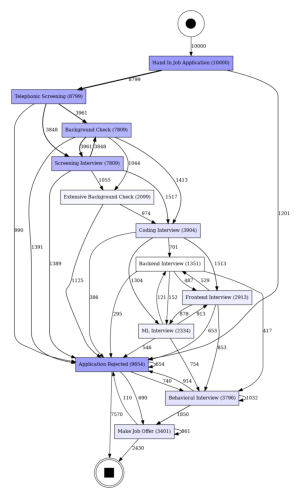

In [281]:
pm.util.constants.DEFAULT_GVIZ_VIEW = 'view'

dfg, start_activities, end_activities = pm.discover_dfg(event_log)
pm.view_dfg(dfg, start_activities, end_activities)

Some applicants had multiple kind of interviews such as 'ML Interview', 'Frontend Interview' or 'Backend Interview'. Since there are no self loops on three activities, there is no bias of taking multiple same kind of interviews. So unfairness can be analysed here whether the applicant was rejected or not on basis of critical attributes.

To better study unfairness, we abstract the three events to 'Domain Interview'

In [282]:
processed_event_log = event_log.copy()

In [283]:
processed_event_log['activity'] = processed_event_log['activity'].where(
    ~processed_event_log['activity'].isin(['ML Interview', 'Frontend Interview', 'Backend Interview']),
    'Domain Interview'
)

processed_event_log['concept:name'] = processed_event_log['concept:name'].where(
    ~processed_event_log['concept:name'].isin(['ML Interview', 'Frontend Interview', 'Backend Interview']),
    'Domain Interview'
)

In [284]:
processed_event_log[processed_event_log['concept:name']=='Domain Interview'].head()

,activity,resource,time,concept:name,time:timestamp,@@index,case:concept:name,case:german speaking,case:yearsOfEducation,case:age,case:gender,case:citizen,case:protected,case:@@case_index,case:case,case:religious,start_timestamp
6,Domain Interview,Coding Interviewer,2015-01-10 05:01:37+00:00,Domain Interview,2015-01-10 05:01:37+00:00,6,1,False,6,30,True,True,False,0,1,True,2015-01-10 05:01:37+00:00
7,Domain Interview,Coding Interviewer,2015-01-10 05:01:37+00:00,Domain Interview,2015-01-10 05:01:37+00:00,7,1,False,6,30,True,True,False,0,1,True,2015-01-10 05:01:37+00:00
17,Domain Interview,Coding Interviewer,2015-01-09 06:48:54+00:00,Domain Interview,2015-01-09 06:48:54+00:00,17,10,True,13,52,True,True,False,1,10,True,2015-01-09 06:48:54+00:00
18,Domain Interview,Coding Interviewer,2015-01-09 06:48:54+00:00,Domain Interview,2015-01-09 06:48:54+00:00,18,10,True,13,52,True,True,False,1,10,True,2015-01-09 06:48:54+00:00
34,Domain Interview,Coding Interviewer,2015-01-09 06:53:23+00:00,Domain Interview,2015-01-09 06:53:23+00:00,34,10000,False,4,39,True,True,False,4,10000,False,2015-01-09 06:53:23+00:00


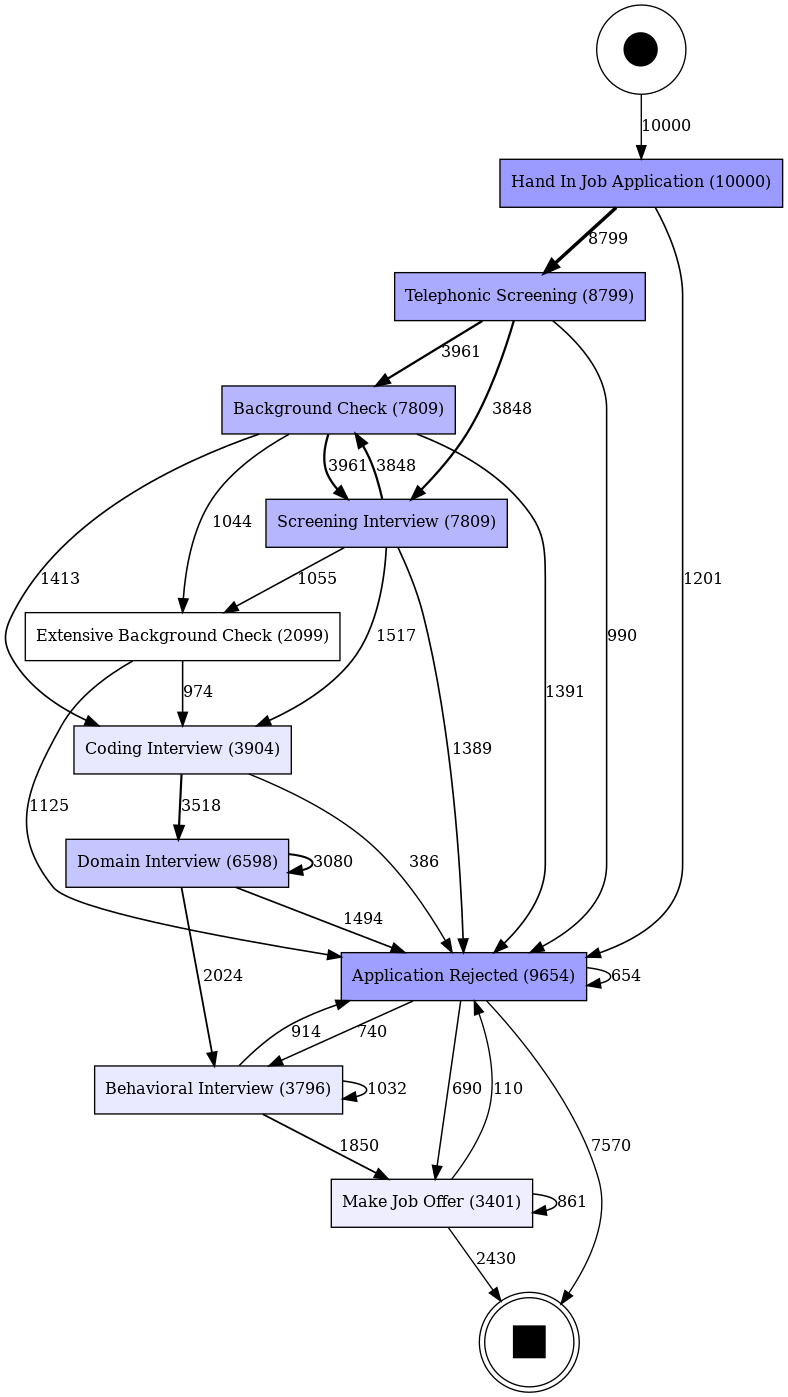

In [285]:
pm.util.constants.DEFAULT_GVIZ_VIEW = 'view'

dfg, start_activities, end_activities = pm.discover_dfg(processed_event_log)
pm.view_dfg(dfg, start_activities, end_activities)

### Self-loops

There are three self-loops in the above DFG:
- Domain Interview: as discussed above, domain interview is abstract name for three particular kind of interviews. Companies usually do multiple domain interviews after talking to candidate and analysing their skill. So this self-loop can be removed.
- Application Rejected and Make Job Offer: This means that a notification had to be sent multiple times and does not reflect biasness at all. This self-loop can be removed.

In [286]:
processed_event_log.head(12)

,activity,resource,time,concept:name,time:timestamp,@@index,case:concept:name,case:german speaking,case:yearsOfEducation,case:age,case:gender,case:citizen,case:protected,case:@@case_index,case:case,case:religious,start_timestamp
0,Hand In Job Application,Front Desk,2015-01-05 00:00:08+00:00,Hand In Job Application,2015-01-05 00:00:08+00:00,0,1,False,6,30,True,True,False,0,1,True,2015-01-05 00:00:08+00:00
1,Telephonic Screening,HR-dummy,2015-01-05 22:12:58+00:00,Telephonic Screening,2015-01-05 22:12:58+00:00,1,1,False,6,30,True,True,False,0,1,True,2015-01-05 22:12:58+00:00
2,Screening Interview,HR-dummy,2015-01-06 20:26:13+00:00,Screening Interview,2015-01-06 20:26:13+00:00,2,1,False,6,30,True,True,False,0,1,True,2015-01-06 20:26:13+00:00
3,Background Check,HR-dummy,2015-01-06 20:26:13+00:00,Background Check,2015-01-06 20:26:13+00:00,3,1,False,6,30,True,True,False,0,1,True,2015-01-06 20:26:13+00:00
4,Extensive Background Check,deepResearch Inc.,2015-01-07 18:41:19+00:00,Extensive Background Check,2015-01-07 18:41:19+00:00,4,1,False,6,30,True,True,False,0,1,True,2015-01-07 18:41:19+00:00
5,Coding Interview,Coding Interviewer,2015-01-09 06:49:30+00:00,Coding Interview,2015-01-09 06:49:30+00:00,5,1,False,6,30,True,True,False,0,1,True,2015-01-09 06:49:30+00:00
6,Domain Interview,Coding Interviewer,2015-01-10 05:01:37+00:00,Domain Interview,2015-01-10 05:01:37+00:00,6,1,False,6,30,True,True,False,0,1,True,2015-01-10 05:01:37+00:00
7,Domain Interview,Coding Interviewer,2015-01-10 05:01:37+00:00,Domain Interview,2015-01-10 05:01:37+00:00,7,1,False,6,30,True,True,False,0,1,True,2015-01-10 05:01:37+00:00
8,Behavioral Interview,HR-pro and Senior Partner,2015-01-11 03:14:45+00:00,Behavioral Interview,2015-01-11 03:14:45+00:00,8,1,False,6,30,True,True,False,0,1,True,2015-01-11 03:14:45+00:00
9,Behavioral Interview,HR-pro and Senior Partner,2015-01-11 03:16:08+00:00,Behavioral Interview,2015-01-11 03:16:08+00:00,9,1,False,6,30,True,True,False,0,1,True,2015-01-11 03:16:08+00:00


In [287]:
processed_event_log = processed_event_log.sort_values(['case:concept:name', 'time:timestamp'])
processed_event_log['previous_activity'] = processed_event_log['concept:name'].shift(1)
processed_event_log['previous_case'] = processed_event_log['case:concept:name'].shift(1)

processed_event_log[['concept:name', 'previous_activity', 'previous_case', 'case:concept:name']].head()

,concept:name,previous_activity,previous_case,case:concept:name
0,Hand In Job Application,None,None,1
1,Telephonic Screening,Hand In Job Application,1,1
2,Screening Interview,Telephonic Screening,1,1
3,Background Check,Screening Interview,1,1
4,Extensive Background Check,Background Check,1,1


In [288]:
final_log = processed_event_log[
        ~((
            # self loops in Domain Interview
            (processed_event_log['concept:name']=='Domain Interview') &
            (processed_event_log['previous_activity']=='Domain Interview') &
            (processed_event_log['case:concept:name']==processed_event_log['previous_case'])
        ) |
        (
            # self loops in Application Rejected
            (processed_event_log['concept:name']=='Application Rejected') &
            (processed_event_log['previous_activity']=='Application Rejected') &
            (processed_event_log['case:concept:name']==processed_event_log['previous_case'])
        ) |
        (
            # self loops in Make Job Offer
            (processed_event_log['concept:name']=='Make Job Offer') &
            (processed_event_log['previous_activity']=='Make Job Offer') &
            (processed_event_log['case:concept:name']==processed_event_log['previous_case'])
        ))
]

final_log = final_log.drop(columns=['previous_activity', 'previous_case'])

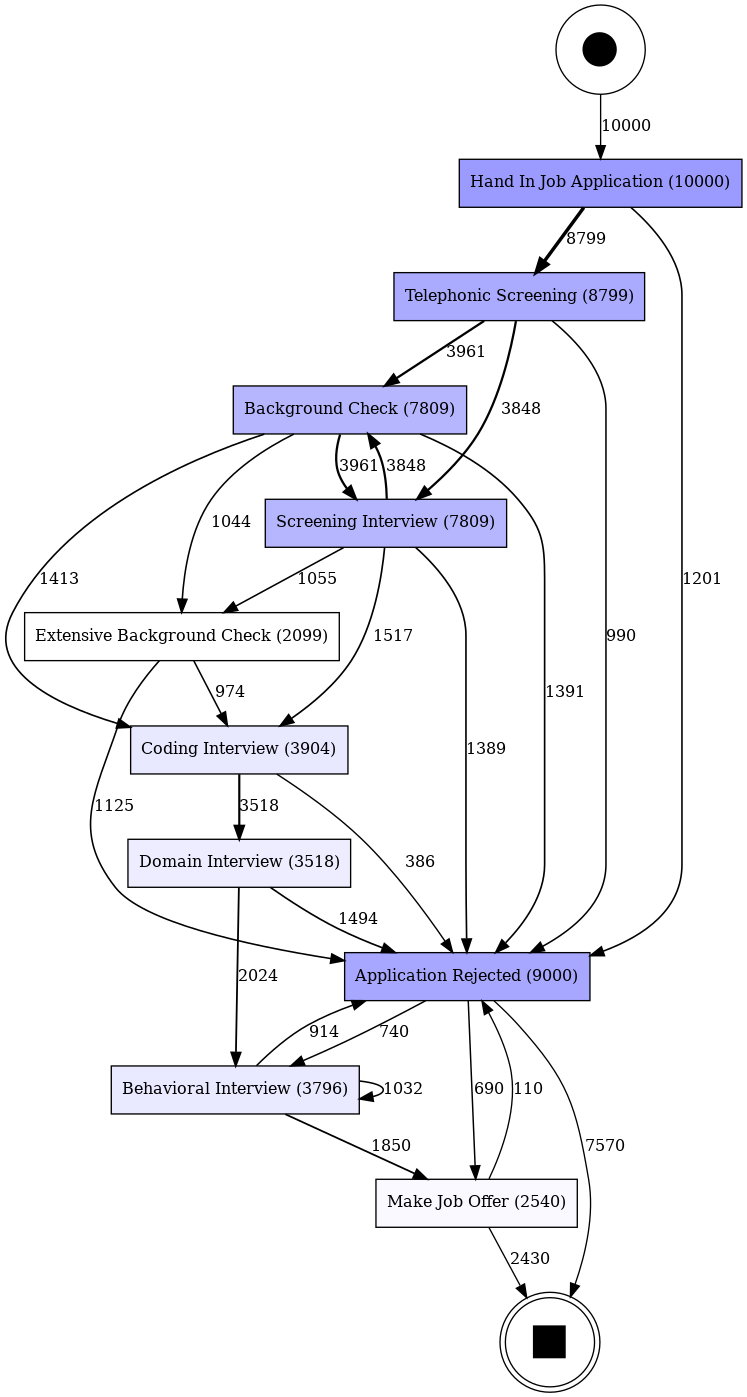

In [289]:
pm.util.constants.DEFAULT_GVIZ_VIEW = 'view'

dfg, start_activities, end_activities = pm.discover_dfg(final_log)
pm.view_dfg(dfg, start_activities, end_activities)

In [290]:
print(f"Possible values of german speaking {event_log['case:german speaking'].unique()}")
print(f"Possible values of age {event_log['case:age'].unique()}")
print(f"Possible values of gender {event_log['case:gender'].unique()}")
print(f"Possible values of citizen {event_log['case:citizen'].unique()}")
print(f"Possible values of religious {event_log['case:religious'].unique()}")

Possible values of german speaking [False  True]
Possible values of age [30 52 38 47 39 50 37 62 48 59 31 49 43 61 34 55 58 32 51 35 53 46 60 64
 41 56 73 75 70 44 63 66 57 29 54 40 68 36 72 45 65 42 67 33 69 76 74 77
 71 28 27 79 26 80 23 24 19 22 81 20 85 82 25 14 78 17 15 18 84 21 91 10
 87 86]
Possible values of gender [ True False]
Possible values of citizen [ True False]
Possible values of religious [ True False]


## Biasness in overall process of hiring

In [321]:
critical_boolean_attributes = ['german speaking', 'gender', 'citizen', 'religious']

case_durations = {}
discovered_performance_dfg = {}
all_cases_duration = np.mean(pm.stats.get_all_case_durations(event_log))

for attribute in critical_boolean_attributes:
    case_durations[attribute] = {
        'True': np.mean(pm.stats.get_all_case_durations(event_log[event_log[f"case:{attribute}"]])),
        'False': np.mean(pm.stats.get_all_case_durations(event_log[~event_log[f"case:{attribute}"]]))
    }

    discovered_performance_dfg[attribute] = {
        'True': pm.discover_performance_dfg(event_log[event_log[f"case:{attribute}"]]),
        'False': pm.discover_performance_dfg(event_log[~event_log[f"case:{attribute}"]])
    }

clear_output()

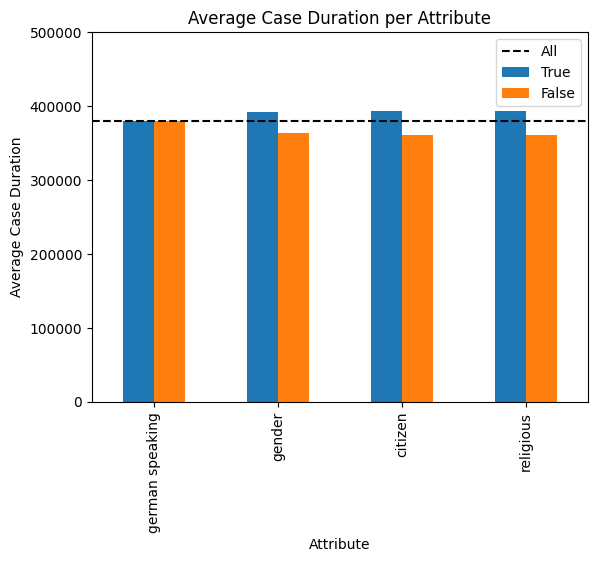

In [292]:
ax = pd.DataFrame(case_durations).transpose().plot(kind='bar')
ax.set_ylim([0,500000])
ax.axhline(all_cases_duration, color='black', linestyle='--', label='All')
ax.legend()
ax.set_xlabel('Attribute')
ax.set_ylabel('Average Case Duration')
_ = ax.set_title('Average Case Duration per Attribute')

The average case duration shows a difference between two classes of gender, citizen and religious showing some indication of biasness.  
One possible reason for this could be some additional formalities to be taken care of in hiring process.

/home/chirag/anaconda3/envs/process-mining/lib/python3.11/site-packages/pm4py/visualization/common/gview.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, w_pad=0, h_pad=0)


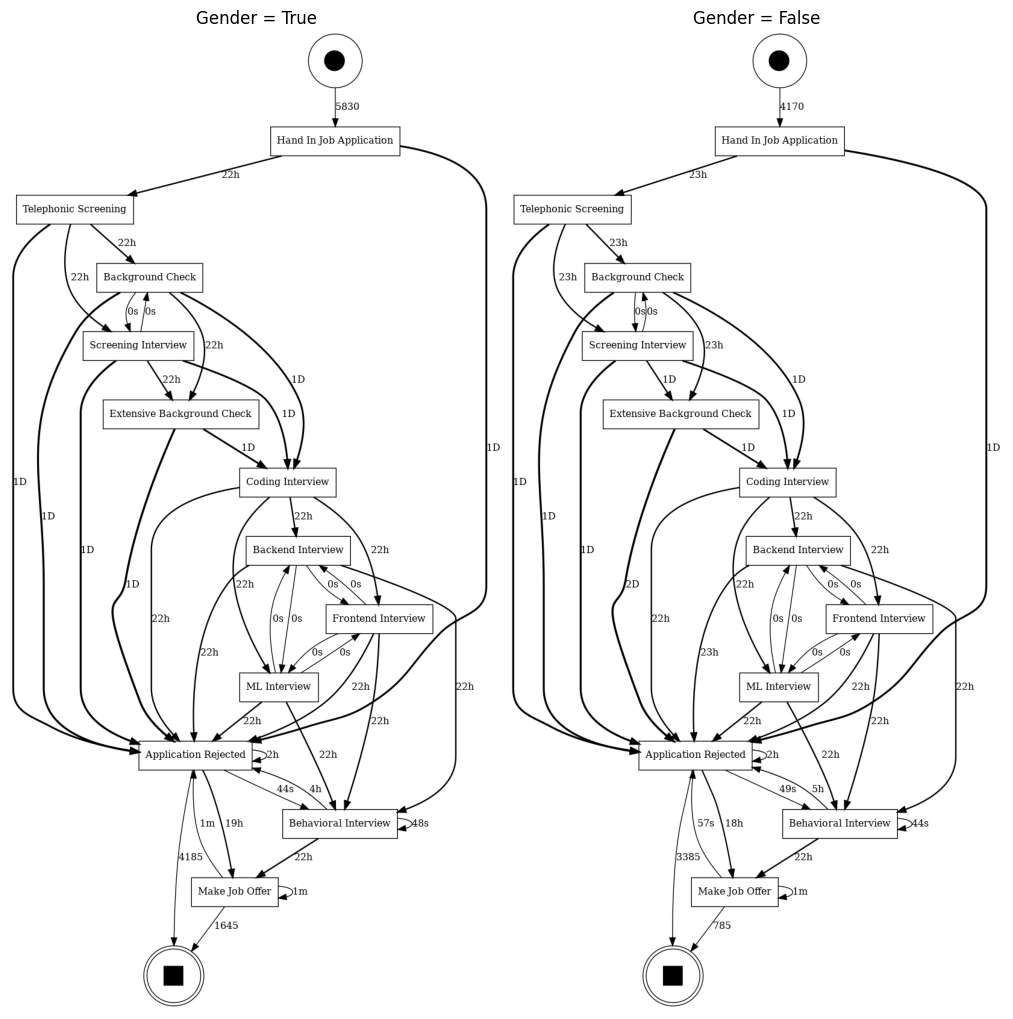

In [319]:
pm.util.constants.DEFAULT_GVIZ_VIEW = 'matplotlib_view'

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,10))

ax[0].set_title("Gender = True")
ax[1].set_title("Gender = False")

plt.sca(ax[0])
pm.view_performance_dfg(*discovered_performance_dfg['gender']['True'])

clear_output()

plt.sca(ax[1])
_ = pm.view_performance_dfg(*discovered_performance_dfg['gender']['False'])

/home/chirag/anaconda3/envs/process-mining/lib/python3.11/site-packages/pm4py/visualization/common/gview.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, w_pad=0, h_pad=0)


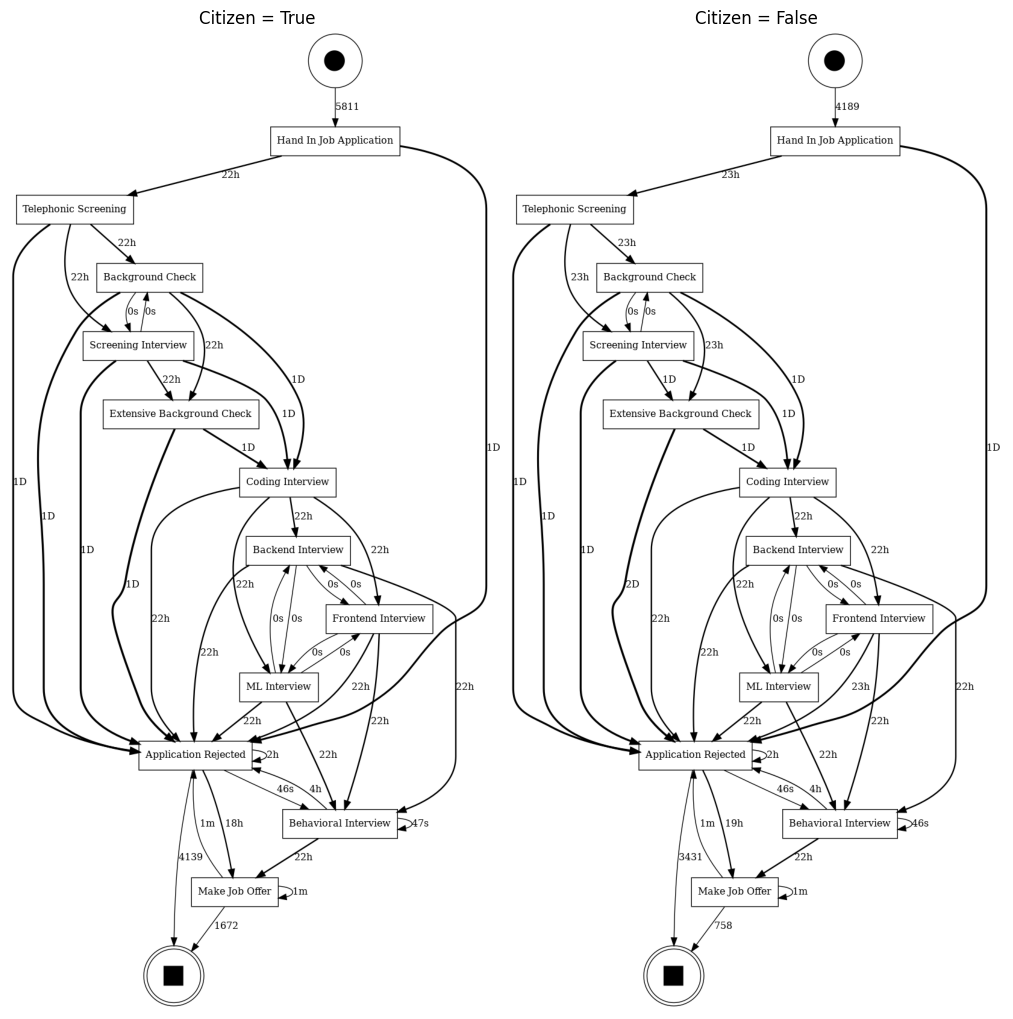

In [318]:
pm.util.constants.DEFAULT_GVIZ_VIEW = 'matplotlib_view'

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,10))

ax[0].set_title("Citizen = True")
ax[1].set_title("Citizen = False")

plt.sca(ax[0])
pm.view_performance_dfg(*discovered_performance_dfg['citizen']['True'])

clear_output()

plt.sca(ax[1])
_ = pm.view_performance_dfg(*discovered_performance_dfg['citizen']['False'])

/home/chirag/anaconda3/envs/process-mining/lib/python3.11/site-packages/pm4py/visualization/common/gview.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, w_pad=0, h_pad=0)


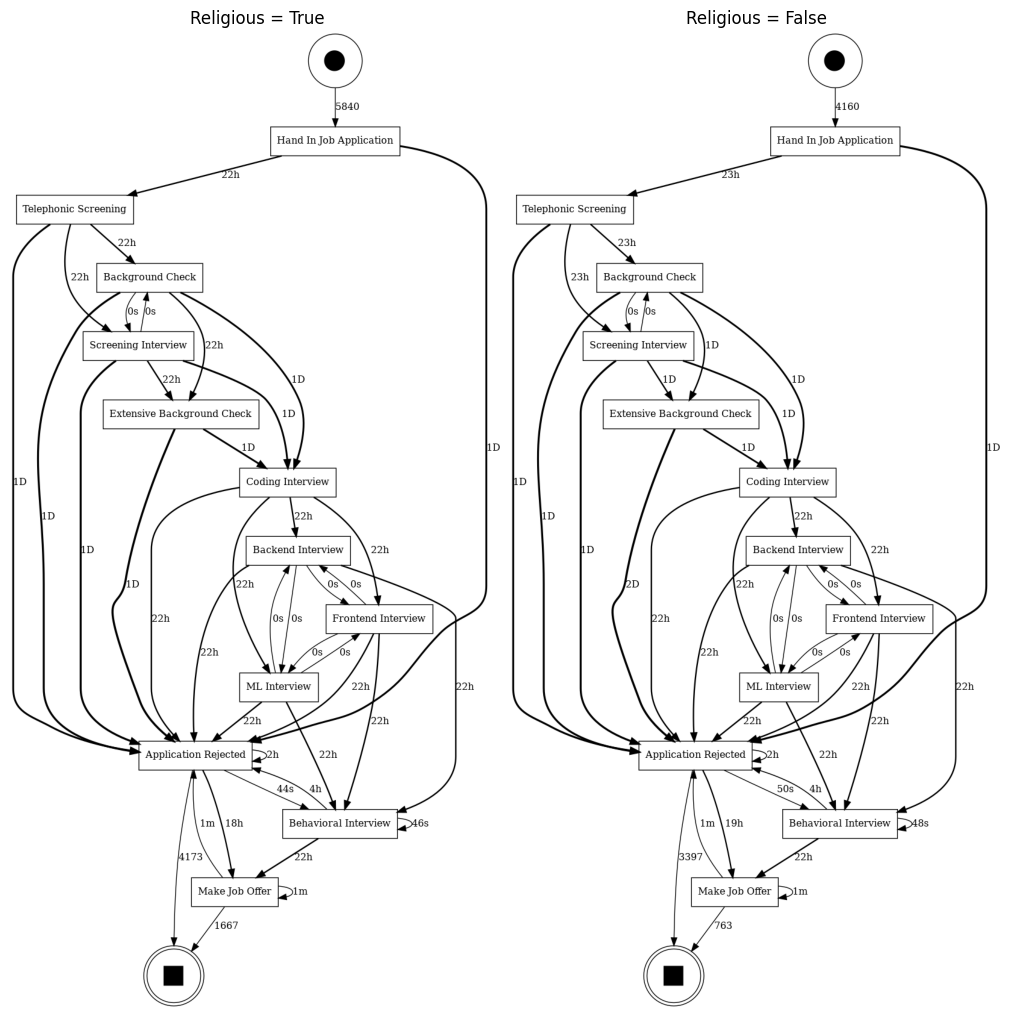

In [317]:
pm.util.constants.DEFAULT_GVIZ_VIEW = 'matplotlib_view'

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,10))

ax[0].set_title("Religious = True")
ax[1].set_title("Religious = False")

plt.sca(ax[0])
pm.view_performance_dfg(*discovered_performance_dfg['religious']['True'])

clear_output()

plt.sca(ax[1])
_ = pm.view_performance_dfg(*discovered_performance_dfg['religious']['False'])

From the DFGs above for three critical attributes (gender, citizen and religious), time taken till activity 'Extensive Background Check' is more for cases where `attribute = False` than `attribute = True`

In [296]:
event_log['case:age'].describe()

count    63869.000000
mean        50.436565
std          9.790201
min         10.000000
25%         44.000000
50%         51.000000
75%         57.000000
max         91.000000
Name: case:age, dtype: float64

In [325]:
age_bins = [(10,20),(20,40),(40,60),(60,91)]

age_bins_duration = []
dfg_performance_per_age_bin = []

for bin in age_bins:
    age_event_log = event_log[(event_log['case:age']>=bin[0])&(event_log['case:age']<bin[1])]

    age_bins_duration.append(
        np.mean(pm.stats.get_all_case_durations(age_event_log))
    )

    dfg_performance_per_age_bin.append(pm.discover_performance_dfg(age_event_log))

clear_output()

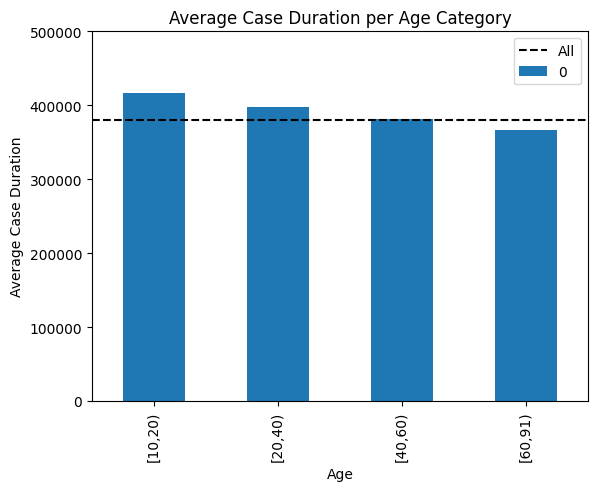

In [298]:
ax = pd.DataFrame(age_bins_duration,index=[f"[{bin[0]},{bin[1]})" for bin in age_bins]).plot(kind='bar', legend=False)
ax.set_ylim([0,500000])
ax.axhline(all_cases_duration, color='black', linestyle='--', label='All')
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Average Case Duration')
_ = ax.set_title('Average Case Duration per Age Category')

As the age increases, the overall hiring process becomes shorter. Again, if this means biasness or not, can only be confirmed by looking at time spent in each activity for each age category

/home/chirag/anaconda3/envs/process-mining/lib/python3.11/site-packages/pm4py/visualization/common/gview.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, w_pad=0, h_pad=0)


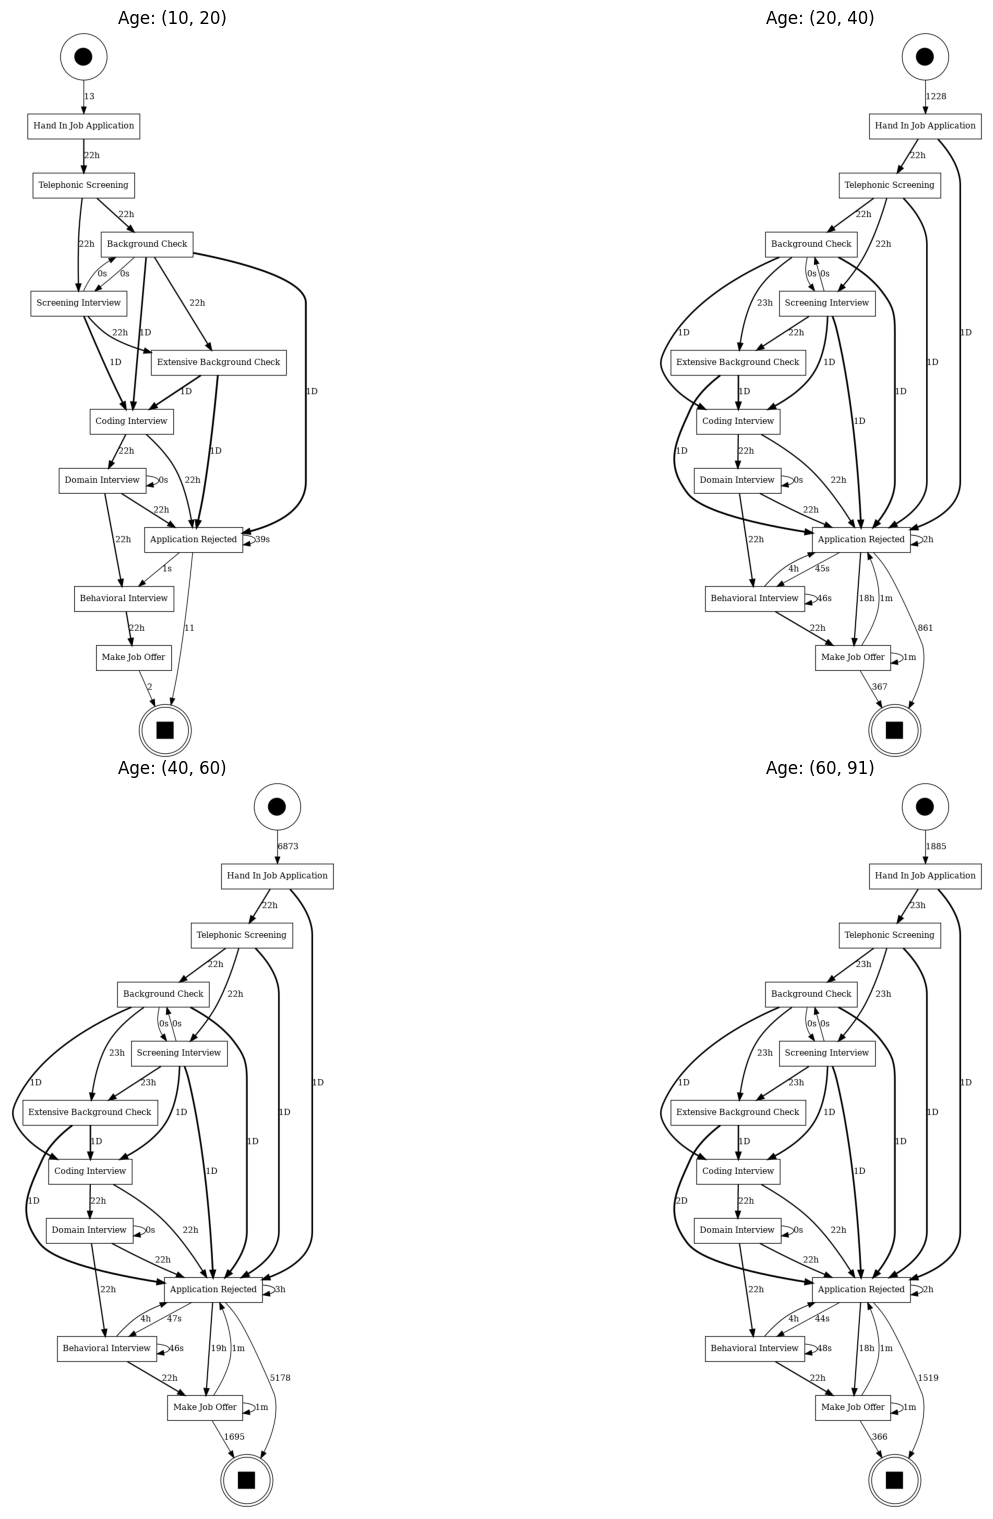

In [343]:
pm.util.constants.DEFAULT_GVIZ_VIEW = 'matplotlib_view'

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

count = 0
for i in ax:
    for j in i:
        plt.sca(j)
        j.set_title(f"Age: {age_bins[count]}")
        pm.view_performance_dfg(*dfg_performance_per_age_bin[count])
        count += 1


        if count <= 3:
            clear_output()

## Biasness in decision making

In [ ]:
# using decision tree, see if there is bias in at a place with two outgoing arcs

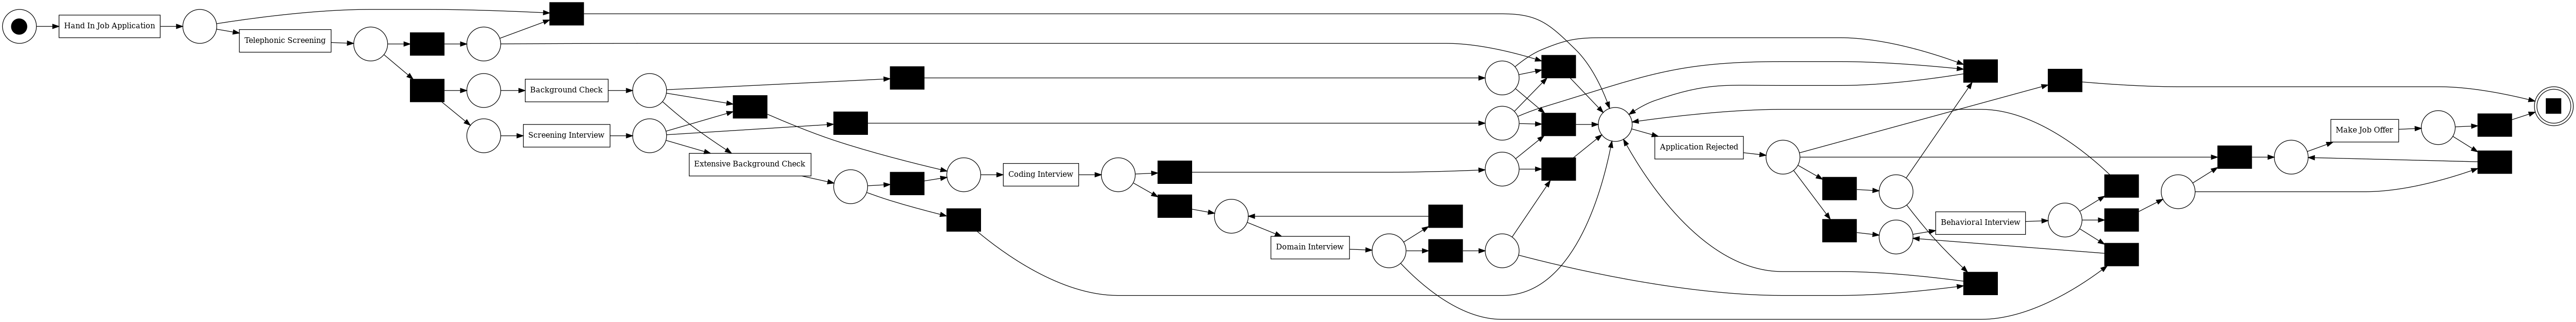

In [352]:
# petri net

from pm4py.algo.discovery.alpha.algorithm import apply as alpha_apply

petri_net, initial_marking, final_marking = pm.discover_petri_net_heuristics(processed_event_log)

pm.vis.view_petri_net(petri_net, initial_marking, final_marking)    

In [ ]:
dfg, start_activities, end_activities = pm.discover_dfg(final_log)
pm4py.algo.discovery.alpha.algorithm.apply_dfg()